# A stabiliser run through

The idea behind this workbook is to run through the main concepts behind the stabilizer code.
In particular we will look at:

- creating and manipulating tableaus.
- plotting routines
- using the stabilizer formalism to look at the [[4,2,2]] code including the logical gates.
- use a tableau to create an arbitrary Clifford circuit.

After all that you will be an expert.

# Some preliminaries

We will need the following, packages installed.

In [1]:
using Juqst

In [2]:
# From the Julia end we need PyCall and PyPlot to call the python code - these packages should already be installed
# if not just follow the instructions in the error message when you try and use them
using PyCall
using PyPlot

## Code to plot circuits

In [3]:
# We can use Quantikz to print the circuits. You may need to add this package.
using Quantikz

# How to use the Tableau

## Tableau sets up the Aaronsen/Gottesman stabiliser

Full details of the stabiliser formalism can be found https://arxiv.org/abs/quant-ph/0406196

Basically we are setting it up in the form of the following stabiliser matrix

$$\left(\begin{array}{ccc|ccc|c}
x_{11} & \dots & x_{1n}& z_{11} &\dots & z_{1n} & r_1 \\
\vdots & \ddots & \vdots& \vdots &\ddots & \vdots & \vdots \\
x_{n1} & \dots & x_{nn}& z_{n1} &\dots & z_{nn} & r_n\\
\hline
x_{(n+1)1} & \dots & x_{(n+1)n}& z_{(n+1)1} &\dots & z_{(n+1)n} & r_{(n+1)} \\
\vdots & \ddots & \vdots& \vdots &\ddots & \vdots & \vdots \\
x_{(2n)1} & \dots & x_{(2n)n}& z_{(2n)1} &\dots & z_{(2n)n} & r_{(2n)}\end{array}\right)
$$

However, just to be different (well really because I found it easier to read), the phase information will be displayed on the left e.g. 

$$\left(\begin{array}{c|ccc|ccc}
r_1 & x_{11} & \dots & x_{1n}& z_{11} &\dots & z_{1n}  \\
\vdots & \vdots & \ddots& \vdots &\vdots & \ddots & \vdots \\
r_{n} & x_{n1} & \dots & x_{nn} & z_{n1} &\dots & z_{nn}\\
\hline
r_{(n+1)} & x_{(n+1)1} & \dots & x_{(n+1)n}& z_{(n+1)1} &\dots & z_{(n+1)n}  \\
\vdots & \vdots & \ddots& \vdots &\vdots & \ddots & \vdots \\
r_{(2n)} & x_{(2n)1} & \dots & x_{(2n)n} & z_{(2n)1} &\dots & z_{(2n)n}\end{array}\right)
$$




- Rows 1 to n of the tableau represent the destabiliser generators ($D$)
- Rows n+1 to 2n represent the stabiliser generators ($S$).
- Each row is read as follows: 
  - if the x<sub>ij</sub> and z<sub>ij</sub> are 1, the de/stabiliser is a Y, 
  - if they are both 0, its I 
  - otherwise its an X or Z depending on which one is set.


### Key point with stabilisers and de-stabilisers

- All the $S_i$ commute with the other $S$. All The $D_i$ commute with the other $D$
- Each $S_i$ anti-commutes with the corresponding $D_i$
- Each $S_i$ commutes with all $D_j$, $i\neq j$

In [4]:
# Create a 3 qubit tableau
t = Tableau(3)


+XII
+IXI
+IIX
----
+ZII
+IZI
+IIZ


# Some basic examples


## How to read this:

If the state $|000\rangle$ is multiplied by any row 'above' the line we get a 1, any row below the line it is zero.


The following commands are defined

```
hadamard(tableau,qubit)      # apply a hadamard to the relevant qubit
phase(tableau,qubit)         # apply a phase gate to the relevant qubit
cnot(tableau,control,target) # apply a controlled not from control qubit to target qubit
X(tableau,qubit)             # apply an X gate to to qubit qubit
Z(tableau,qubit)             # apply a Z gate to to qubit qubit
```

## Let's apply an X gate to see what happens


In [5]:
t = Tableau(3)
X(t,2)
t


+XII
+IXI
+IIX
----
+ZII
-IZI
+IIZ


## So the state is now $|010\rangle$ and we see that -IZI (is now the correct stabilizer state)

## What does a hadamard do?

In [6]:
t = Tableau(3)
hadamard(t,2)
t


+XII
+IZI
+IIX
----
+ZII
+IXI
+IIZ


## Which is what we should be expecting:

We think we should have the state $|000\rangle+|010\rangle$, and this is the one stabilized here. We can print out the kets just to check

In [7]:
print(kets(t))

+|000> 
+|010> 


## The tableau keeps track of the commands that have been applied

In [8]:
t.commands

2-element Vector{String}:
 "initialise(3)"
 "hadamard(2)"

## And if you want to draw or use these you can get them in the form of

- a qiskit circuit (using the qasm language)
- or something you can use with quantikzCircuit

### Let's make it a *bit* more interesting first

In [9]:
cnot(t,2,1)
cnot(t,2,3)

qiskitCircuit - returns a python function that will create the circuit for you.

In [10]:
print(qiskitCircuit(t))

#Pass in the circuit and qubit register
def createCircuit(circs,qreg):
    circs.h(qreg[2])
    circs.cx(qreg[2],qreg[1])
    circs.cx(qreg[2],qreg[3])

In [11]:
function quantikzCircuit(t::Tableau)
	commands = t.commands
    quantikzCommands=[]

    labels=[]
	currentDir = pwd()
	for i = 1:size(commands,1)
		m = match(r"initialise\((.*)\)",commands[i])
		if (m!=nothing)
			for idx=1:Meta.parse(m.captures[1])
    			#push!(quantikzCommands,"qubit q$i")
                push!(labels,"q$idx")
			end
    	else
    		m=match(r"hadamard\((.*)\)",commands[i])
    		if (m!=nothing)
                push!(quantikzCommands,Quantikz.H(parse(Int,m.captures[1])))
    		else
    			m=match(r"phase\((.*)\)",commands[i])
    			if (m!=nothing)
                    push!(quantikzCommands,Quantikz.P(parse(Int,m.captures[1])))
    			else
    				m=match(r"cnot\((.*),(.*)\)",commands[i])
    				if (m!=nothing)
    					push!(quantikzCommands,Quantikz.CNOT(parse(Int,m.captures[1]),parse(Int,m.captures[2])))
    				end
    			end
    		end
    	end
    end
	return quantikzCommands
end


quantikzCircuit (generic function with 1 method)

quantikzCircuit will return a vector of quantikz commands you can use to display it or dump it in your tex file!

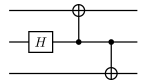

In [12]:
# Convert the ciruit into quantikz commands
c = quantikzCircuit(t)
# Then display it.
displaycircuit(c)

- you could also
```
savecircuit(c,"circuit.pdf")
print(circuit2string(c))
```
See https://github.com/Krastanov/Quantikz for more details

# How does measurement work

Sometimes measurement will be random and sometimes not, depending on the state in question

The command is 

```
measure(tableau,qubit)
```
Basically if there is an 'x' in the stabilisers then it is a random quantum measurement. Below we illustrate how the tableau is altered (again just following the Aaronsen/Gottesman prescription)


In [13]:
# Lets set up an arbitrary state:
s = Tableau(4)
hadamard(s,3)
hadamard(s,2)
cnot(s,2,3)
cnot(s,2,1)
cnot(s,3,4)
print(s)
print("=====\n$(kets(s))\n")


+XIII
+IZII
+IZZI
+IIIX
-----
+ZZII
+XXXX
+IIXX
+IIZZ
=====
+|0000> 
+|1111> 
+|0011> 
+|1100> 



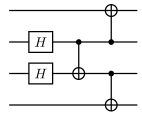

In [14]:
displaycircuit(quantikzCircuit(s))

## What happens if we measure qubit 4?

Well we can see from the kets, that we might measure a 0 or a 1, how does the tableau alter if we measure a 1 on qubit 4?

i.e. what happens if we type 

measure(t,4) and get a 1.

First scan the stabilizers for something with an X in it (if we have that then the measurement is random, not deterministic)


## To check

You may need to run the cell below a few times until you measure a 1!

In [15]:
# Lets set up an arbitrary state:
s = Tableau(4)
hadamard(s,3)
hadamard(s,2)
cnot(s,2,3)
cnot(s,2,1)
cnot(s,3,4)
print("BEFORE measurement \n")
print(s)
print("=====\n$(kets(s))\n")

x = measure(s,4)

if x == 0
    print("We measured a zero\n")
else
    print("*** We measure a one ***\n")
end

print("AFTER measurement \n")
print(s)
print("=====\n$(kets(s))\n")




BEFORE measurement 

+XIII
+IZII
+IZZI
+IIIX
-----
+ZZII
+XXXX
+IIXX
+IIZZ
=====
+|0000> 
+|1111> 
+|0011> 
+|1100> 

*** We measure a one ***
AFTER measurement 

+XIII
+XXXX
+IZZI
+XXXI
-----
+ZZII
-IIIZ
+XXII
+IIZZ
=====
+|0011> 
+|1111> 



# More exciting examples, the [4,2,2] code

## Preliminaries

Here we are going to run through how you might use the stabilizer formalism to explore the 4,2,2 code. This borrows heavily from another Gottesman paper: [Quantum fault tolerance in small experiments](https://arxiv.org/abs/1610.03507), where he discusses how to set it up on a small ring of 5 qubits.

The [4,2,2] code encodes, two logical qubits onto four physical qubits. The distance is only 2, so it can detect when one error has occured, but it doesn't have enough information to correct it. There are a number of uses for such a code.

The code words are as follows (where overline indicates a logical qubit):

- $|\overline{00}\rangle\rightarrow|0000\rangle+|1111\rangle$

- $|\overline{01}\rangle\rightarrow|1100\rangle+|0011\rangle$

- $|\overline{10}\rangle\rightarrow|1010\rangle+|0101\rangle$

- $|\overline{11}\rangle\rightarrow|0110\rangle+|1001\rangle$

The stabilizers of the code are $X\otimes X\otimes X \otimes X$ and $Z\otimes Z\otimes Z \otimes Z$ 

In [16]:
# Create the initial code state:

function codeSetup()
    s = Tableau(5);
    hadamard(s,2,false)
    cnot(s,2,3,false)
    cnot(s,2,1,false)
    cnot(s,3,4,false)
    cnot(s,4,5,false)
    cnot(s,1,5,false)
    return s
end


codeSetup (generic function with 1 method)

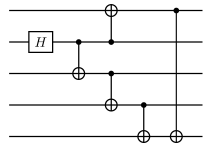

In [17]:
# print it because we can
s =codeSetup()
displaycircuit(quantikzCircuit(s))

In [18]:
# Define a measurement tool

function measureIt(s)
    return join([string(measure(s,i)) for i=1:4])
end

measureIt (generic function with 1 method)

In [19]:
function identifyIt(st)
    if length(st)>4 
        st=st[1:4]
    end
    if st == "0000" || st == "1111"
        return "00"
    elseif st == "1100" || st == "0011"
        return "01"
    elseif st == "1010" || st == "0101"
        return "10"
    elseif st=="0110" || st=="1001"
        return "11"
    else
        return "error"
    end
end



function getLogicalState(s::Tableau)
    # clone it!
    x = deepcopy(s)
    measures = [measure(x,i) for i = 1:4]
    if sum(measures)%2 != 0
        print("Error in state, outside codespace")
        return "XX"
    else
        toReturn = ""
        allString = kets(s)
        ch1 = match(r"([+-])\|0000",allString)
        if ch1 != nothing
            toReturn = toReturn * "$(ch1.captures[1])|00> "
        end
        ch1 = match(r"([+-])\|1100",allString)
        if ch1 != nothing
            toReturn = toReturn * "$(ch1.captures[1])|01> "
        end
        ch1 = match(r"([+-])\|0101",allString)
        if ch1 != nothing
            toReturn = toReturn * "$(ch1.captures[1])|10> "
        end
        ch1 = match(r"([+-])\|1001",allString)
        if ch1 != nothing
            toReturn = toReturn * "$(ch1.captures[1])|11> "
        end
        return toReturn
    end
end

getLogicalState (generic function with 1 method)

In [21]:
# So when we measure the set (first four qubits) it will collapse down into one of the logical 00 states.
for i = 1:9
    s = codeSetup()
    print("$i: $(measureIt(s)) -> $(identifyIt(measureIt(s)))\n")
end

1: 1111 -> 00
2: 0000 -> 00
3: 0000 -> 00
4: 1111 -> 00
5: 0000 -> 00
6: 1111 -> 00
7: 1111 -> 00
8: 0000 -> 00
9: 0000 -> 00


In [22]:
# So when we measure the set (first four qubits) it will collapse down into one of the logical 00 states.
for i = 1:9
    s = codeSetup()
    print("$i: $(getLogicalState(s))\n")
end

1: +|00> 
2: +|00> 
3: +|00> 
4: +|00> 
5: +|00> 
6: +|00> 
7: +|00> 
8: +|00> 
9: +|00> 


In [23]:
t = codeSetup()
p = deepcopy(t)
measureIt(t)


"1111"

In [24]:
kets(t)

"+|11110> \n"

In [25]:
kets(p)

"+|00000> \n+|11110> \n"

In [26]:
# Alternatively we can look at the kets (remember we have a fifth qubit for state prep)
s = codeSetup()
print(kets(s))

+|00000> 
+|11110> 


## Test out the logical operators

In [27]:
function logicalZ(s,a)
    if a == 1
        Z(s,1)
        Z(s,2)
    else
        Z(s,1)
        Z(s,3)
    end
end
       

function logicalX(s,a)
    if a == 1
        X(s,1)
        X(s,3)
    else
        X(s,1)
        X(s,2)
    end
end

function logicalHH(s)
    hadamard(s,1)
    hadamard(s,2)
    hadamard(s,3)
    hadamard(s,4)
end
       

logicalHH (generic function with 1 method)

In [28]:
print("X on first qubit\n")
s = codeSetup()
logicalX(s,1)
print(kets(s))
print("-------->\t|$(identifyIt(measureIt(s)))>\n\n")
print("X on second qubit\n")
s= codeSetup()
logicalX(s,2)
print(kets(s))
print("-------->\t|$(identifyIt(measureIt(s)))>\n\n")



X on first qubit
+|10100> 
+|01010> 
-------->	|10>

X on second qubit
+|11000> 
+|00110> 
-------->	|01>



In [29]:
print("HH on the code, followed by IZ and then another HH -> equivalent of XI (as HH swaps the qubits)\n")
s=codeSetup()
logicalHH(s)
logicalZ(s,2)
logicalHH(s)
print(kets(s))
print("---------->\t|$(identifyIt(measureIt(s)))>\n\n")


HH on the code, followed by IZ and then another HH -> equivalent of XI (as HH swaps the qubits)
+|10100> 
+|01010> 
---------->	|10>



## So what does four phases do? 

Well they are supposed to be a controlled-Z gate, followed by a ZZ gate, so what would that look like in two qubits?

In [30]:
function cZgate(t,control,target) # cZgate (diag(1,1,1,-1))
    # So a CZ gate is just a CX gate with hadmards on either side of the target
    hadamard(t,target)
    cnot(t,control,target)
    hadamard(t,target)
end



cZgate (generic function with 1 method)

The Z and CZ gate doesn't appear to do anything in the computational basis (it changes phase information), so the easiest way to see this is through kets, when we put the tableau into the |+> basis (i.e. hadamard it). So lets look at that for each of the four computational basis states:

In [31]:
t = Tableau(2)
hadamard(t,1)
hadamard(t,2)
print("|00> -> ")
print("$(replace(kets(t),"\n"=>""))\n")

t = Tableau(2)
X(t,1)
hadamard(t,1)
hadamard(t,2)
print("|10> -> ")
print("$(replace(kets(t),"\n"=>""))\n")

t = Tableau(2)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|01> -> ")
print("$(replace(kets(t),"\n"=>""))\n")

t = Tableau(2)
X(t,1)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|11> -> ")
print("$(replace(kets(t),"\n"=>""))\n")


|00> -> +|00> +|10> +|01> +|11> 
|10> -> +|00> -|10> +|01> -|11> 
|01> -> +|00> +|10> -|01> -|11> 
|11> -> +|00> -|10> -|01> +|11> 


So this allows us to examine all the relevant 'phase' information as between the kets.
If we were to call the CZ gate then we would expect the following changes:



In [32]:

t = Tableau(2)
hadamard(t,1)
hadamard(t,2)
print("|00> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
print(" CZ -> $(replace(kets(t),"\n"=>""))\n")




t = Tableau(2)
X(t,1)
hadamard(t,1)
hadamard(t,2)
print("|10> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
print(" CZ -> $(replace(kets(t),"\n"=>""))\n")


t = Tableau(2)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|01> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
print(" CZ -> $(replace(kets(t),"\n"=>""))\n")


t = Tableau(2)
X(t,1)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|11> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
print(" CZ -> $(replace(kets(t),"\n"=>""))\n")




|00> -> +|00> +|10> +|01> +|11>  CZ -> +|00> +|10> +|01> -|11> 
|10> -> +|00> -|10> +|01> -|11>  CZ -> +|00> -|10> +|01> +|11> 
|01> -> +|00> +|10> -|01> -|11>  CZ -> +|00> +|10> -|01> +|11> 
|11> -> +|00> -|10> -|01> +|11>  CZ -> +|00> -|10> -|01> -|11> 


Where (hopefully) it is clear that the sign of the |11> ket is the only thing that has changed.
Of course the four phases is not a CZ gate, but a CZ gate followed by a ZZ gate, so the following should happen:


In [33]:

t = Tableau(2)
hadamard(t,1)
hadamard(t,2)
print("|00> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
Z(t,1)
Z(t,2)
print(" CZ ZZ -> $(replace(kets(t),"\n"=>""))\n")




t = Tableau(2)
X(t,1)
hadamard(t,1)
hadamard(t,2)
print("|10> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
Z(t,1)
Z(t,2)
print(" CZ ZZ -> $(replace(kets(t),"\n"=>""))\n")



t = Tableau(2)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|01> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
Z(t,1)
Z(t,2)
print(" CZ ZZ -> $(replace(kets(t),"\n"=>""))\n")


t = Tableau(2)
X(t,1)
X(t,2)
hadamard(t,1)
hadamard(t,2)
print("|11> -> ")
print("$(replace(kets(t),"\n"=>""))")
cZgate(t,1,2)
Z(t,1)
Z(t,2)
print(" CZ ZZ -> $(replace(kets(t),"\n"=>""))\n")

|00> -> +|00> +|10> +|01> +|11>  CZ ZZ -> +|00> -|10> -|01> -|11> 
|10> -> +|00> -|10> +|01> -|11>  CZ ZZ -> +|00> +|10> -|01> +|11> 
|01> -> +|00> +|10> -|01> -|11>  CZ ZZ -> +|00> -|10> +|01> +|11> 
|11> -> +|00> -|10> -|01> +|11>  CZ ZZ -> +|00> +|10> +|01> -|11> 


i.e all the signs change, except for the |00>.

We can now do the same thing when looking at the code.

In [34]:
# A round of hadamards does the same thing 
# where it should be clear that we just getting each computational basis state in superposition.
s = codeSetup()
logicalHH(s)
print(replace(kets(s),"\n"=>""))
print("\nOr in logical basis\n")
print(getLogicalState(s))

+|00000> +|11000> +|01100> +|10100> +|00110> +|11110> +|01010> +|10010> 
Or in logical basis
+|00> +|01> +|10> +|11> 

Then when we apply the phases we would expect them all to be negative other than |00000> and |11110>

In [35]:
function applyPhases(s)
    for i = 1:4
        phase(s,i)
    end
end

s = codeSetup()
logicalHH(s)
applyPhases(s)
print(replace(kets(s),"\n"=>""))
print("\nOr in logical basis\n")
print(getLogicalState(s))

+|00000> -|11000> -|01100> -|10100> -|00110> +|11110> -|01010> -|10010> 
Or in logical basis
+|00> -|01> -|10> -|11> 

Similarly with the others, we would expect ALL the signs to change other than |00000> and |11110>

In [36]:
s = codeSetup()
logicalX(s,1)
logicalHH(s)
print("XI: $(replace(kets(s),"\n"=>""))\n")
applyPhases(s)
print("->: $(replace(kets(s),"\n"=>""))\n")
print("------------------------------------------------------------------------------------------------\n")
s = codeSetup()
logicalX(s,2)
logicalHH(s)
print("IX: $(replace(kets(s),"\n"=>""))\n")
applyPhases(s)
print("->: $(replace(kets(s),"\n"=>""))\n")
print("------------------------------------------------------------------------------------------------\n")
s = codeSetup()
logicalX(s,1)
logicalX(s,2)
logicalHH(s)
print("XX: $(replace(kets(s),"\n"=>""))\n")
applyPhases(s)
print("->: $(replace(kets(s),"\n"=>""))\n")
print("------------------------------------------------------------------------------------------------\n")

print("\n\nOr thinking about this logically\n\n")

s = codeSetup()
logicalX(s,1)
logicalHH(s)
print("XI: $(getLogicalState(s))\n")
applyPhases(s)
print("->: $(getLogicalState(s))\n")
print("------------------------------------------------------------------------------------------------\n")
s = codeSetup()
logicalX(s,2)
logicalHH(s)
print("IX: $(getLogicalState(s))\n")
applyPhases(s)
print("->: $(getLogicalState(s))\n")
print("------------------------------------------------------------------------------------------------\n")
s = codeSetup()
logicalX(s,1)
logicalX(s,2)
logicalHH(s)
print("XX: $(getLogicalState(s))\n")
applyPhases(s)
print("->: $(getLogicalState(s))\n")
print("------------------------------------------------------------------------------------------------\n")

XI: +|00000> -|11000> -|01100> +|10100> -|00110> +|11110> +|01010> -|10010> 
->: +|00000> +|11000> +|01100> -|10100> +|00110> +|11110> -|01010> +|10010> 
------------------------------------------------------------------------------------------------
IX: +|00000> +|11000> -|01100> -|10100> +|00110> +|11110> -|01010> -|10010> 
->: +|00000> -|11000> +|01100> +|10100> -|00110> +|11110> +|01010> +|10010> 
------------------------------------------------------------------------------------------------
XX: +|00000> -|11000> +|01100> -|10100> -|00110> +|11110> -|01010> +|10010> 
->: +|00000> +|11000> -|01100> +|10100> +|00110> +|11110> +|01010> -|10010> 
------------------------------------------------------------------------------------------------


Or thinking about this logically

XI: +|00> -|01> +|10> -|11> 
->: +|00> +|01> -|10> +|11> 
------------------------------------------------------------------------------------------------
IX: +|00> +|01> -|10> -|11> 
->: +|00> -|01> +|10> +|11>

### Works as advertised!

# Cliffords and stabilizers oh my!

Here I will briefly discuss the 'symplectic' mapping between numbers and Cliffords. More details in: Koenig/Smolin arXiv:quant-ph/1406.2170
[Koenig/Smolin arXiv:quant-ph/1406.2170](https://arxiv.org/abs/1406.2170)

The easiest way to get a stabilised state that represents the actions of a Clifford on the start state is to use the inbuilt cliffordToTableau and tableauToClifford commands.

This is a one-one mapping between the integers and the cliffords
For each 'symplectic' the X, and Z maps (the rows in the Tableaus) can be +1 or -1 which means
There are an additional 2^d*2^d cliffords 'per' symplectic, in the stabilizer formalism this is the $r_1\ldots r_{2n}$ of the matrix above



- So cliffordToTableau(7,62345,0) gives you the mapping for 7 qubit, symplectic 62345
- tableauToClifford(x::Tableau), will give you the 'number' of the clifford (modulo the phase stuff)



In [37]:
x = cliffordToTableau(7,62345,0)


+XYIZYIY
+ZZIZYIY
+IIXIIII
+ZYIYYIY
+ZYIZZIY
+IIIIIXI
+ZYIZYIZ
--------
+XXIIIII
+XIIZYIY
+IIZIIII
+IIIZIII
+ZYIZXIY
+IIIIIZI
+ZYIZYIX


In [38]:
tableauToClifford(x)

62345

In [39]:
# Note the +/- changes
x = cliffordToTableau(7,62345,10)


+XYIZYIY
-ZZIZYIY
+IIXIIII
-ZYIYYIY
+ZYIZZIY
+IIIIIXI
+ZYIZYIZ
--------
+XXIIIII
+XIIZYIY
+IIZIIII
+IIIZIII
+ZYIZXIY
+IIIIIZI
+ZYIZYIX


In [40]:
# Modulo the phase stuff
tableauToClifford(x)

62345

We might want to make the cliffords

In [41]:
twoClifford = cliffordToTableau(2,2341,3)
actualClifford = round.(makeFromCommand(twoClifford),digits=10)

4×4 Matrix{ComplexF64}:
  0.5+0.0im  0.0+0.5im   0.5+0.0im  -0.0-0.5im
 -0.5+0.0im  0.0+0.5im  -0.5+0.0im  -0.0-0.5im
 -0.5+0.0im  0.0-0.5im   0.5+0.0im  -0.0-0.5im
  0.5+0.0im  0.0-0.5im  -0.5+0.0im  -0.0-0.5im

or decompose it to see the commands that make it up, these are unlikely to be optimal.

In [42]:
twoClifford.commands

13-element Vector{String}:
 "initialise(2)"
 "phase(2)"
 "phase(2)"
 "phase(1)"
 "phase(1)"
 "hadamard(2)"
 "hadamard(1)"
 "cnot(2,1)"
 "phase(1)"
 "cnot(2,1)"
 "phase(1)"
 "phase(1)"
 "phase(1)"

In [43]:
#We can qiskit it.
print(qiskitCircuit(twoClifford))

#Pass in the circuit and qubit register
def createCircuit(circs,qreg):
    circs.s(qreg[2])
    circs.s(qreg[2])
    circs.s(qreg[1])
    circs.s(qreg[1])
    circs.h(qreg[2])
    circs.h(qreg[1])
    circs.cx(qreg[2],qreg[1])
    circs.s(qreg[1])
    circs.cx(qreg[2],qreg[1])
    circs.s(qreg[1])
    circs.s(qreg[1])
    circs.s(qreg[1])

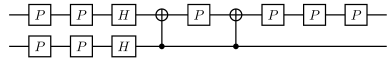

In [44]:
# or draw it
displaycircuit(quantikzCircuit(twoClifford))

In [45]:
# or superOperator it
makeSuper(actualClifford)

16×16 Matrix{Float64}:
 1.0   0.0  0.0   0.0   0.0   0.0  …  0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0  -1.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  1.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0  -1.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0  -1.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0  …  0.0  0.0  0.0   0.0  0.0   0.0  1.0
 0.0  -1.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  1.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  1.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0  …  0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0  -1.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0   0.0   0.0   0.0     0.0  0.0  0.0   0.0  0.0   0.0  0.0
 0.0   0.0  0.0

In [46]:
# if we are curious there are this many 'symplectic' three qubit cliffords
getNumberOfSymplecticCliffords(3)

1451520

In [47]:
# and phases
getNumberOfBitStringsCliffords(3)

64

In [48]:
# for a total of 
getNumberOfSymplecticCliffords(3)*getNumberOfBitStringsCliffords(3)

92897280

In [49]:
# or just
getNumberOfCliffords(3)

92897280

In [50]:
# With seven its a big number!
getNumberOfSymplecticCliffords(7)

27930968965434591767112450048000

In [51]:
# But we use BigInt so its ok!
c7 = cliffordToTableau(7,27930968965434591767112450047999,0)


+YYYYYYY
+IYYYYYY
+IIYYYYY
+IIIYYYY
+IIIIYYY
+IIIIIYY
+IIIIIIY
--------
+XIIIIII
+XZYYYYY
+IXZYYYY
+IIXZYYY
+IIIXZYY
+IIIIXZY
+IIIIIXZ


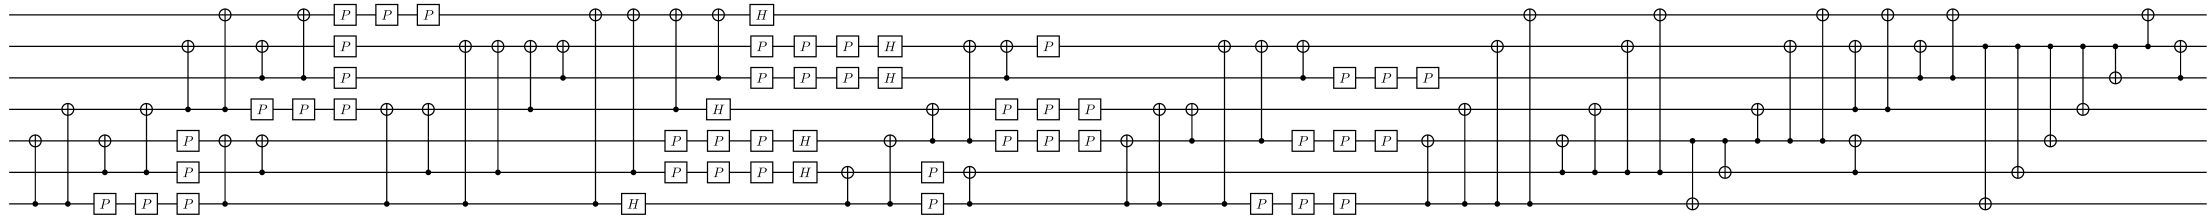

In [52]:
displaycircuit(quantikzCircuit(c7))

In [53]:
# Want a the stabilizers of a random 14 qubit Clifford?
ct = cliffordToTableau(10,rand(1:getNumberOfSymplecticCliffords(10)),1)


-IIXXIZZIYY
+ZZIZXIXZXX
+IIXIXYYIXZ
+IZYYYXXYXZ
+ZIYIXYZXII
+XYZIIZIZXI
+YYZZYZYYXY
+YXZZXIIXYI
+ZZXIYYZXYX
+XXIXXXXZXZ
-----------
+XZIZZIYYIX
+XIYZYIXYIX
+XYIZXXXYXY
+IIXZXZYZYI
+IXIXZIIIYI
+YYZXXIZXYX
+XXZZIYIXZI
+YZYZZZXXIZ
+IIZXZYIIYY
+IYXZXIIYXI


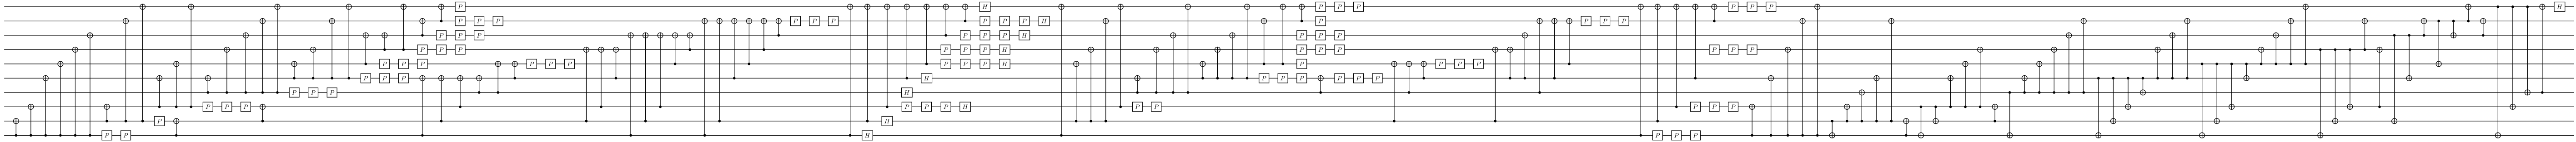

In [54]:
displaycircuit(quantikzCircuit(ct))

but I am certainly not game to try and turn that into a superoperator (a matrix of $2^{20} \times 2^{20}$)

However, if we keep things small we can certainly use this to generate all the Cliffords. So for instance if you wanted superoperators for all of the two qubit cliffords (11,520 of them). You could do the following:

In [55]:
twoQubitCliffords = []
for i = 1:getNumberOfSymplecticCliffords(2)
    for j = 1:getNumberOfBitStringsCliffords(2)
        push!(twoQubitCliffords,makeSuper(makeFromCommand(cliffordToTableau(2,i,j))))
    end
end
print("$(length(twoQubitCliffords)) - created.\n")

11520 - created.


## Supplementary information

### Note - this is the old method of printing circuts.

I have migrated to using Quantikz.jl, which is a lot nicer. The following code is still present, but unless you are having problems with Quantikz.jl, just ignore.


If you want to plot circuits, then you will also need the following additional code:

Note: if you don't need to plot the circuits, then just ignore.

The code is based on a python package called PlotQCircuit (by Rick Muller). There is some Julia Code that acts as a bridge into this. It's perfectly easy to load, we just need the correct files in the correct places, unfortunately I haven't yet figured out a better way to do this.

The julia code needs to be specified in the include statement. Just now that is in an 'additionalJuliaCode' folder, which is directly off the directory this workbook is run in.

The python code is in a directory called 'additionalPythonCode', this is the fidly one. It NEEDS to be in the working directory of the jupyter notebook (typically the directory it is run in). If you are not sure you can run the command:

`
pwd()
`

and make sure that you have the 'additionalPythonCode' folder (which must also contain the PlotQCircuit folder) in that directory. (or change the current working directory or change the code in plotCircuits.jl to load the correct directory).
If this is not correct, you will typically get something like `PyError (PyImport_ImportModule` which basically means it could NOT find the code we need.
